# Creation of dataframe for gravity model

- join on cityname
- create city dataframe (nodes)
- create separate city-pairs dataframes (basically edges)
- calculate distances

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
from tqdm.notebook import tqdm
import unidecode
from collections import Counter
from shapely.geometry import Point, LineString, Polygon

In [2]:
INDIR = "../../input"
OUTDIR = "../../output"
DATADIR = "../../../../data"
FILE_cities = "List_of_cities_300k.csv"
FILE_coords = "euro-global-map-shp/data/FullEurope/BuiltupP.shp" #path/to/eucoordinates/shapefile

In [3]:
# load citylist
list_of_cities = pd.read_csv(os.path.join(INDIR, FILE_cities), sep=";")
list_of_cities.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,EU15,Code_Country,NUTS_1,NUTS_2,NUTS_3,...,PUR,Supra_poly_fua,PIA,Name_supra_poly_fua,Poly_fua,id_poly_fua,Name_poly_fua,SizeHinterland1k,GDP_per_capita,Dummy_Capital
0,FR00810,Paris,Paris,Paris,9591,1,FR,FR1,FR10,FR101,...,,0,PIA_Paris,99,0,,,1201,44,1
1,UK01886,London,London,Londres,8256,1,UK,UKI,UKI1,UKI11,...,,0,PIA_London,99,0,,,2752,45,1
2,ES00540,Madrid,Madrid,Madrid,4955,1,ES,ES3,ES30,ES300,...,,0,PIA_Madrid,99,0,,,308,29,1
3,DE00219,Berlin,Berlin,Berlin,3776,1,DE,DE3,DE30,DE300,...,,0,PIA_Berlin,99,0,,,240,22,1
4,IT01156,Milano,Milan,Milan,3698,1,IT,ITC,ITC4,ITC45,...,Milano,0,PIA_Milano,99,1,IT03,Milano metropolitan area,604,35,0


## Select relevant coordinates

In [4]:
# load data with city coordinates
built_up = gpd.read_file(os.path.join(DATADIR, FILE_coords))

In [5]:
built_up.shape

(72846, 18)

In [6]:
built_up.head()

,OBJECTID,FCsubtype,inspireId,beginLifes,F_CODE,ICC,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,PPL,PP1,PP2,USE,PopulatedP,geometry
0,1,1,_EG.EGM.BuiltupP:40c2730a-3a4b-474b-8f55-615cd...,20220125104612,AL020,MD,Cernoleuca,UNK,Cernoleuca,UNK,rum,UNK,1771,-32768,-32768,3,N.MD.BUILTUP.000823,POINT (27.56031 48.31269)
1,2,1,_EG.EGM.BuiltupP:f90e3db3-2ef5-4cf7-95ba-2f99f...,20220125104612,AL020,MD,Mo?ana,UNK,Mosana,UNK,rum,UNK,1630,-32768,-32768,3,N.MD.BUILTUP.000825,POINT (27.68990 48.32328)
2,3,1,_EG.EGM.BuiltupP:d947c478-818e-41ed-91a2-0aa79...,20220125104612,AL020,MD,Gribova,UNK,Gribova,UNK,rum,UNK,2101,-32768,-32768,3,N.MD.BUILTUP.000831,POINT (27.93089 48.01388)
3,4,1,_EG.EGM.BuiltupP:0f9b7f83-5249-4030-9933-417ed...,20220125104612,AL020,MD,Chirca,UNK,Chirca,UNK,rum,UNK,1704,-32768,-32768,3,N.MD.BUILTUP.000838,POINT (29.10819 46.92171)
4,5,1,_EG.EGM.BuiltupP:0e4be3d7-1937-4614-a7fd-f6bd2...,20220125104612,AL020,MD,Delac?u,UNK,Delacau,UNK,rum,UNK,2126,-32768,-32768,3,N.MD.BUILTUP.000840,POINT (29.30339 47.09902)


`BuiltUpP.shp` contains 4 different name variables. `NAMN1`, `NAMN2`, `NAMA1`, and `NAMA2`. The first two are names in up to two national languages. The latter are transliterated versions of those names into ASCII characters. 

In [7]:
muas = list(list_of_cities.Mua)

In [8]:
# create a dictionary of toponyms and their country codes
mua_dict = dict()

for index, row in list_of_cities.iterrows():
    if row['Code_Country'] == 'UK': 
        mua_dict[row['Mua']] = 'GB'
    else: 
        mua_dict[row['Mua']] = row['Code_Country']
    

### Names with issues:

At least some of these non matches are combined cities. For these it is probably easiest to choose the coordinates of one. (although i guess the best option would be to calculate the midpoint between the combined cities and then take that);

Another problem is that unidecode replaces 'ü' with 'u' while the `NAMA1` variable lists this with 'ue'. Same for 'oe'.

Den Haag --> 's-Gravenhage (den Haag listed as NAMA2)

**Manual edits**

Antwerp listed with its dutch/flemish name Antwerpen. Brussels as Brussel

Don't understand what is happening to Lyon and Marseille. (listed only with arrondissement numbers in name, e.g. 'Lyon 1er Arrondissement')

error for Gent (negative population number)  
Sofia should be done manually as well (other Sofias are present but Sofia, BU is listed as 'S?fiya')

Stoke --> Stoke-on-Trent
Belfast cause country code does not match

Plovdiv --> Pl?vdiv

Wuppertal not in the dataset. 

suggested process:
1. un-decoded (so with accents). match to NAMA1 first. 
2. Then new list with left over cities, match to NAMN1 (for the umlauts).
3. left-over match to NAMN2
4. Manually match remaining cities




### First Match
Match the cities in the built_up dataset with the cities in the CITYNET network by confirming that name and country match.

In [9]:
cities = []
for index, row in built_up.iterrows(): 
    if row['NAMA1'] in mua_dict and row['ICC'] == mua_dict[row['NAMA1']]:
        cities.append(row['NAMA1'])
    elif row['NAMN1'] in mua_dict and row['ICC'] == mua_dict[row['NAMN1']]:
        cities.append(row['NAMN1'])
    elif row['NAMN2'] in mua_dict and row['ICC'] == mua_dict[row['NAMN2']]: 
        cities.append(row['NAMN2'])

In [10]:
# check how many cities have been matched
len(cities)

137

In [11]:
# check if any cities have been matched more than once
city_counts = Counter(cities) 
for key in city_counts:
    if city_counts[key] > 1:
        print(key)

Bremen
Leeds


In [12]:
# cities not automatically matched
leftovers = []
for city in muas:
    if city not in cities:
        leftovers.append(city)

In [13]:
print(leftovers)

['Brussels', 'Kobenhavn', 'Lyon', 'Sofia', 'Essen-Oberhausen', 'Marseille', 'Antwerp', 'Bochum-Herne', 'Gelsenkirchen-Bottrop', 'Belfast', 'Palma de Mallorca', 'Wuppertal', 'Castellammare di Stabia-Torre Annunziata', 'Plovdiv', 'Alicanta', 'La Coruna']


Matched: 135 cities  
False Match: Bremen and Leeds duplicates

Cities not matched:  
'Brussels', 'Kobenhavn', 'Lyon', 'Sofia', 'Essen-Oberhausen', 'Marseille', 'Antwerp', 'Bochum-Herne', 'Gelsenkirchen-Bottrop', 'Belfast', 'Palma de Mallorca', 'Wuppertal', 'Castellammare di Stabia-Torre Annunziata', 'Plovdiv', 'Alicanta', 'La Coruna'

These cities remain unmatched for a variety of issues.
* language differences (e.g. Brussels, Alicante)
* different name (e.g. Marseille, Mallorca, A Coruna)
* different transliteration (e.g.Plovdiv, Kobenhavn, Sofia)
* MUA is made up of multiple cities (e.g. Castellammare di Stabia-Torre Annunziata)
* Belfast isn't matched cause the country codes don't match (the coordinate dataset uses a separate CC for northern ireland)

One of the cities has no match because it is not present in the coordinate dataset: Wuppertal

Considering the small size of the unmatched city list. A dictionary was created manually to match the diverging names in the two datasets

In [14]:
# dictionary of non matching names
manual_names_v = {"Pl?vdiv":"Plovdiv", 
                "S?fiya":"Sofia", 
                "Koebenhavn": "Kobenhavn", 
                "Brussel": "Brussels", 
                "Antwerpen": "Antwerp",
                "A Coruna": "La Coruna", 
                "Alacant/Alicante": "Alicanta", 
                "Lyon 1er Arrondissement": "Lyon", 
                "Marseille 1er Arrondissement": "Marseille", 
                "Mallorca": "Palma de Mallorca"}

In [15]:
# add first one of the compound cities to the dictionary
for city in leftovers:
    if '-' in city:
        manual_names_v[city.split('-')[0]] = city

In [16]:
# full dictionary
manual_names_v

{'Pl?vdiv': 'Plovdiv',
 'S?fiya': 'Sofia',
 'Koebenhavn': 'Kobenhavn',
 'Brussel': 'Brussels',
 'Antwerpen': 'Antwerp',
 'A Coruna': 'La Coruna',
 'Alacant/Alicante': 'Alicanta',
 'Lyon 1er Arrondissement': 'Lyon',
 'Marseille 1er Arrondissement': 'Marseille',
 'Mallorca': 'Palma de Mallorca',
 'Essen': 'Essen-Oberhausen',
 'Bochum': 'Bochum-Herne',
 'Gelsenkirchen': 'Gelsenkirchen-Bottrop',
 'Castellammare di Stabia': 'Castellammare di Stabia-Torre Annunziata'}

In [17]:
# reverse of dictionary
manual_names_r = {value: key for key, value in manual_names_v.items()}

In [18]:
# add new spellings to the original city : country code dictionary
for key in manual_names_v:
    # create new mua_dict key from the name dictionary and gives it the same country code as the corresponding name
    mua_dict[key] = mua_dict[manual_names_v[key]]

### Match with this new dictionary

In [19]:
cities = []
for index, row in built_up.iterrows(): 
    if row['NAMA1'] in mua_dict and row['ICC'] == mua_dict[row['NAMA1']]:
        cities.append(tuple(row))
    elif row['NAMN1'] in mua_dict and row['ICC'] == mua_dict[row['NAMN1']]:
        cities.append(tuple(row))
    elif row['NAMN2'] in mua_dict and row['ICC'] == mua_dict[row['NAMN2']]: 
        cities.append(tuple(row))
    # don't require country code match for Belfast (there is only one Belfast in the dataset)
    elif row['NAMA1'] == "Belfast": 
        cities.append(tuple(row))

In [20]:
df = pd.DataFrame(cities, columns = built_up.columns)
df.shape

(152, 18)

In [21]:
df.head()

,OBJECTID,FCsubtype,inspireId,beginLifes,F_CODE,ICC,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,PPL,PP1,PP2,USE,PopulatedP,geometry
0,1331,2,_EG.EGM.BuiltupP:22ad56b0-8466-40b2-94eb-33e32...,20220125104612,AL022,NL,Utrecht,UNK,Utrecht,UNK,dut,UNK,305240,-32768,-32768,2,N.NL.BUILTUP.000116,POINT (5.111481999999796 52.09862549999983)
1,1339,2,_EG.EGM.BuiltupP:610f3331-bf58-429c-a74d-8f280...,20220125104612,AL022,NL,Eindhoven,UNK,Eindhoven,UNK,dut,UNK,228545,-32768,-32768,3,N.NL.BUILTUP.000247,POINT (5.472336499999784 51.457088499999855)
2,1347,2,_EG.EGM.BuiltupP:df56f111-3a4b-4593-b750-f34eb...,20220125104612,AL022,NL,Amsterdam,UNK,Amsterdam,UNK,dut,UNK,861985,-32768,-32768,1,N.NL.BUILTUP.000110,POINT (4.874293499999794 52.37074349999983)
3,1373,2,_EG.EGM.BuiltupP:c41a764f-1c42-4c97-b10b-f338d...,20220125104612,AL022,NL,Rotterdam,UNK,Rotterdam,UNK,dut,UNK,583140,-32768,-32768,3,N.NL.BUILTUP.000009,POINT (4.473741999999788 51.92364099999983)
4,4397,2,_EG.EGM.BuiltupP:2646a7da-071b-49d4-8209-fa15a...,20220125104612,AL022,PL,Pozna?,UNK,Poznan,UNK,pol,UNK,550700,-32768,-32768,2,N.PL.BUILTUP.0969400,POINT (16.917509499999795 52.40734099999983)


In [22]:
# exclude the duplicate Bremen and Leeds
# Wrong BREMEN 27573
# Wrong LEEDS 63132
duplicate_IDs = [27573, 63132]

# done this way because that way the projection metadata is preserved
gdf = built_up[(~built_up.OBJECTID.isin(duplicate_IDs)) & (built_up.OBJECTID.isin(df.OBJECTID))]

In [23]:
# save as shapefile
fp = os.path.join(DATADIR, "city_coordinates.shp")
gdf.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


**Wuppertal:**
Wuppertal is not in the EGM dataset, added manually in QGIS based on OpenStreetMap data.

In [24]:
# load file with wuppertal coordinates also included
coords = gpd.read_file(os.path.join(DATADIR, "city_coordinates_complete.shp"))

In [25]:
coords.head()

,OBJECTID,FCsubtype,inspireId,beginLifes,F_CODE,ICC,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,PPL,PP1,PP2,USE,PopulatedP,geometry
0,1331.0,2.0,_EG.EGM.BuiltupP:22ad56b0-8466-40b2-94eb-33e32...,20220125104612,AL022,NL,Utrecht,UNK,Utrecht,UNK,dut,UNK,305240.0,-32768.0,-32768.0,2.0,N.NL.BUILTUP.000116,POINT (5.11148 52.09863)
1,1339.0,2.0,_EG.EGM.BuiltupP:610f3331-bf58-429c-a74d-8f280...,20220125104612,AL022,NL,Eindhoven,UNK,Eindhoven,UNK,dut,UNK,228545.0,-32768.0,-32768.0,3.0,N.NL.BUILTUP.000247,POINT (5.47234 51.45709)
2,1347.0,2.0,_EG.EGM.BuiltupP:df56f111-3a4b-4593-b750-f34eb...,20220125104612,AL022,NL,Amsterdam,UNK,Amsterdam,UNK,dut,UNK,861985.0,-32768.0,-32768.0,1.0,N.NL.BUILTUP.000110,POINT (4.87429 52.37074)
3,1373.0,2.0,_EG.EGM.BuiltupP:c41a764f-1c42-4c97-b10b-f338d...,20220125104612,AL022,NL,Rotterdam,UNK,Rotterdam,UNK,dut,UNK,583140.0,-32768.0,-32768.0,3.0,N.NL.BUILTUP.000009,POINT (4.47374 51.92364)
4,4397.0,2.0,_EG.EGM.BuiltupP:2646a7da-071b-49d4-8209-fa15a...,20220125104612,AL022,PL,Pozna?,UNK,Poznan,UNK,pol,UNK,550700.0,-32768.0,-32768.0,2.0,N.PL.BUILTUP.0969400,POINT (16.91751 52.40734)


## Create Cities dataframe

following columns: Mua, Mua_en, Mua_fr, population, country_code, geometry, (dummies: fr_dum, en_dum, additional disambiguation dummies).  



In [26]:
df = list_of_cities.copy()
df = df[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']]
df.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,Code_Country
0,FR00810,Paris,Paris,Paris,9591,FR
1,UK01886,London,London,Londres,8256,UK
2,ES00540,Madrid,Madrid,Madrid,4955,ES
3,DE00219,Berlin,Berlin,Berlin,3776,DE
4,IT01156,Milano,Milan,Milan,3698,IT


In [27]:
# change the names in coords so that they match the names in the cities dataframe
coords.replace({'NAMA1': manual_names_v}, inplace=True)

In [28]:
output_df = []
for index, row in coords.iterrows(): 
    for index2, row2 in df.iterrows(): 
        if row['NAMA1'] == row2['Mua']:
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))
        elif row['NAMN1'] == row2['Mua']:
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))
        elif row['NAMN2'] == row2['Mua']: 
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))

In [29]:
# transform to GeoDataFrame
output_df = gpd.GeoDataFrame(output_df, columns = ['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country', 'geometry'], crs = coords.crs)


<AxesSubplot:>

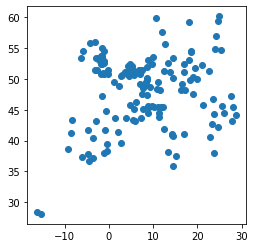

In [30]:
output_df.plot()

In [31]:
output_df.crs

<Geographic 2D CRS: EPSG:4258>
Name: ETRS89
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Moldova; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain; Sweden; Switzerland; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-16.1, 32.88, 40.18, 84.73)
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [32]:
# rename columns to avoid name being cut off when saving
output_df.rename(columns = {'Code_Country': 'CC', 'SizeMUA1k': 'POP', 'Mua_en': 'MUA'}, inplace = True)
output_df.drop(['Mua_fr', 'Mua', 'id_MUA'], axis = 1, inplace = True)

In [33]:
output_df.head()

,MUA,POP,CC,geometry
0,Utrecht,390,NL,POINT (5.11148 52.09863)
1,Eindhoven,316,NL,POINT (5.47234 51.45709)
2,Amsterdam,1052,NL,POINT (4.87429 52.37074)
3,Rotterdam,1025,NL,POINT (4.47374 51.92364)
4,Poznan,679,PL,POINT (16.91751 52.40734)


In [34]:
## if you want to save a version of the coordinate shapefile without the dummy values
# fp = os.path.join(INDIR, "city_coordinates.shp")
# output_df.to_file(fp)

### European area zone dummies
*  Central and Eastern Europe
*  Northern Europe
*  Southern Europe
*  Western Europe
https://eur-lex.europa.eu/browse/eurovoc.html?params=72,7206,914#arrow_914
eurovoc

Central and Eastern Europe

     Albania
     Armenia
     Azerbaijan
     Belarus
     Bosnia and Herzegovina
     Bulgaria
     Czech Republic
     Croatia
     Georgia
     Hungary
     Moldova
     Montenegro
     North Macedonia
     Poland
     Romania
     Russia
     Serbia
     Slovakia
     Slovenia
     Ukraine

Northern Europe

     Denmark
     Estonia
     Finland
     Iceland
     Latvia
     Lithuania
     Norway
     Sweden

Southern Europe

     Cyprus
     Greece
      Holy See
     Italy
     Malta
     Portugal
     San Marino
     Spain
     Turkey [2]

Western Europe

     Andorra
     Austria
     Belgium
     France
     Germany
     Ireland
     Liechtenstein
     Luxembourg
     Monaco
     Netherlands
      Switzerland
     United Kingdom

In [35]:
west = ['AT', 'BE', 'FR', 'DE', 'IE', 'NL', 'CH', 'UK']
south =  ['GR', 'IT', 'MT', 'PT', 'ES']
north = ['DK', 'EE', 'FI', 'LV', 'LT', 'NO', 'SE']
central_east = ['PL', 'RO', 'HU', 'CZ', 'BG', 'SK']

len(west) + len(south) + len(north) + len(central_east)

26

In [36]:
output_df['WEST'] = np.where((output_df['CC'].isin(west)), 1, 0)
output_df['SOUTH'] = np.where((output_df['CC'].isin(south)), 1, 0)
output_df['NORTH'] = np.where((output_df['CC'].isin(north)), 1, 0)
output_df['CEAST'] = np.where((output_df['CC'].isin(central_east)), 1, 0)

In [37]:
def region_lab(row): 
    if row['WEST'] == 1: 
        region = 'west'
    elif row['CEAST'] == 1:
        region = 'central_east'
    elif row['NORTH'] == 1: 
        region = 'north'
    else: 
        region = 'south'
    return region

In [38]:
output_df['REGION'] = output_df.apply(region_lab, axis = 1)

In [39]:
output_df.head()

,MUA,POP,CC,geometry,WEST,SOUTH,NORTH,CEAST,REGION
0,Utrecht,390,NL,POINT (5.11148 52.09863),1,0,0,0,west
1,Eindhoven,316,NL,POINT (5.47234 51.45709),1,0,0,0,west
2,Amsterdam,1052,NL,POINT (4.87429 52.37074),1,0,0,0,west
3,Rotterdam,1025,NL,POINT (4.47374 51.92364),1,0,0,0,west
4,Poznan,679,PL,POINT (16.91751 52.40734),0,0,0,1,central_east


In [40]:
output_df[output_df['SOUTH'] == 0]

,MUA,POP,CC,geometry,WEST,SOUTH,NORTH,CEAST,REGION
0,Utrecht,390,NL,POINT (5.11148 52.09863),1,0,0,0,west
1,Eindhoven,316,NL,POINT (5.47234 51.45709),1,0,0,0,west
2,Amsterdam,1052,NL,POINT (4.87429 52.37074),1,0,0,0,west
3,Rotterdam,1025,NL,POINT (4.47374 51.92364),1,0,0,0,west
4,Poznan,679,PL,POINT (16.91751 52.40734),0,0,0,1,central_east
...,...,...,...,...,...,...,...,...,...
146,Kaunas,379,LT,POINT (23.97909 54.91259),0,0,1,0,north
147,Vilnius,554,LT,POINT (25.25660 54.70552),0,0,1,0,north
148,Riga,764,LV,POINT (24.12673 56.95894),0,0,1,0,north
149,Berlin,3776,DE,POINT (13.40554 52.51767),1,0,0,0,west


### Language Sphere dummies

Add language sphere dummies (1 if the city is English or French speaking).

In [41]:
# create english language sphere dummy based on country code
output_df['EN_DUM'] = np.where((output_df['CC']== 'UK') | (output_df['CC'] == 'IE'), 1, 0)

In [43]:
# French-speaking cities in countries which speak french only in certain regions
french_sphere = ['Charleroi', 'Liège', 'Brussels', 'Geneva']

# french dummy CC French or city from previous list
fr_dum = []
for i, row in output_df.iterrows(): 
    if row['MUA'] in french_sphere:
        fr_dum.append(1)
    elif row['CC'] == 'FR':
        fr_dum.append(1)
    else:
        fr_dum.append(0)

# add to dataframe
output_df['FR_DUM'] = fr_dum

In [44]:
output_df.head()

,MUA,POP,CC,geometry,WEST,SOUTH,NORTH,CEAST,REGION,EN_DUM,FR_DUM
0,Utrecht,390,NL,POINT (5.11148 52.09863),1,0,0,0,west,0,0
1,Eindhoven,316,NL,POINT (5.47234 51.45709),1,0,0,0,west,0,0
2,Amsterdam,1052,NL,POINT (4.87429 52.37074),1,0,0,0,west,0,0
3,Rotterdam,1025,NL,POINT (4.47374 51.92364),1,0,0,0,west,0,0
4,Poznan,679,PL,POINT (16.91751 52.40734),0,0,0,1,central_east,0,0


In [45]:
fp = os.path.join(INDIR, "nodes.shp")
# output_df.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
